<a href="https://colab.research.google.com/github/arman258/CNG-562/blob/master/Negar_Arman_Shima_Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Bitcoin Price Prediction (LightWeight CSV)***

In [0]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? Y




# ***Downloading Dataset from Kaggle***

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

Import your Kaggle API

In [0]:
from google.colab import files
files.upload()

In [0]:
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [0]:
! kaggle datasets download team-ai/bitcoin-price-prediction --unzip

  0% 0.00/37.5k [00:00<?, ?B/s]
100% 37.5k/37.5k [00:00<00:00, 34.7MB/s]


In [0]:
!mv bitcoin_price_1week_Test\ -\ Test.csv test.csv
!mv bitcoin_price_Training\ -\ Training.csv train.csv


# ***Data prepration***

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math


In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print (train.shape)
print (test.shape)
train.head()



(1556, 7)
(7, 7)


,Date,Open,High,Low,Close,Volume,Market Cap
0,"Jul 31, 2017",2763.24,2889.62,2720.61,2875.34,"860,575,000","45,535,800,000"
1,"Jul 30, 2017",2724.39,2758.53,2644.85,2757.18,"705,943,000","44,890,700,000"
2,"Jul 29, 2017",2807.02,2808.76,2692.80,2726.45,"803,746,000","46,246,700,000"
3,"Jul 28, 2017",2679.73,2897.45,2679.73,2809.01,"1,380,100,000","44,144,400,000"
4,"Jul 27, 2017",2538.71,2693.32,2529.34,2671.78,"789,104,000","41,816,500,000"


### ***Inverse order of data(from 2013 till 2017)***

In [0]:
train = train.sort_index(ascending=False)
test = test.sort_index(ascending=False)

In [0]:
train.head()

,Date,Open,High,Low,Close,Volume,Market Cap
1555,"Apr 28, 2013",135.30,135.98,132.10,134.21,-,"1,500,520,000"
1554,"Apr 29, 2013",134.44,147.49,134.00,144.54,-,"1,491,160,000"
1553,"Apr 30, 2013",144.00,146.93,134.05,139.00,-,"1,597,780,000"
1552,"May 01, 2013",139.00,139.89,107.72,116.99,-,"1,542,820,000"
1551,"May 02, 2013",116.38,125.60,92.28,105.21,-,"1,292,190,000"


In [0]:
test.head()

,Date,Open,High,Low,Close,Volume,Market Cap
6,"Aug 01, 2017",2871.30,2921.35,2685.61,2718.26,"1,324,670,000","47,321,800,000"
5,"Aug 02, 2017",2727.13,2762.53,2668.59,2710.67,"1,094,950,000","44,950,800,000"
4,"Aug 03, 2017",2709.56,2813.31,2685.14,2804.73,"804,797,000","44,666,400,000"
3,"Aug 04, 2017",2806.93,2899.33,2743.72,2895.89,"1,002,120,000","46,276,200,000"
2,"Aug 05, 2017",2897.63,3290.01,2874.83,3252.91,"1,945,700,000","47,778,200,000"


In [0]:
import plotly 
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='arman258', api_key='kS7nwWGtDkVqZsx9kHkw')


In [0]:
dates = train["Date"]
open_data = train["Open"]
close_data = train["Close"]
high_data = train["High"]
low_data = train["Low"]


In [0]:
trace = go.Candlestick(x=dates,open=open_data,high=high_data,low=low_data,close=close_data)
layout = go.Layout(
    title='Bitcoin Value',
    xaxis = dict(
        rangeslider = dict(
            visible = False
        )
    )
)

data=[trace]

In [0]:
fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename='Bitcoin_Price')

In [0]:
train['Date'] = pd.to_datetime(train.Date,format="%b %d, %Y") 

test['Date'] = pd.to_datetime(test.Date,format="%b %d, %Y") 


In [0]:
train.set_index("Date",inplace=True)
test.set_index("Date",inplace=True)

In [0]:
train.head(3)


,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,-,"1,500,520,000"
2013-04-29,134.44,147.49,134.00,144.54,-,"1,491,160,000"
2013-04-30,144.00,146.93,134.05,139.00,-,"1,597,780,000"


In [0]:
train.dtypes

Open          float64
High          float64
Low           float64
Close         float64
Volume         object
Market Cap     object
dtype: object

In [0]:
def trading_indicator(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    
    # Create Moving Average Convergence/Divergence
    dataset['26ema'] = dataset['Close'].ewm(adjust=False,span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(adjust=False,span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
#     dataset['20sd'] = pd.stats.moments.rolling_std(dataset['close'],20)
    dataset['20sd'] = dataset['Close'].rolling(20).std()

    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = np.log(dataset['Close']-1)
    
    return dataset

In [0]:
df_TI = trading_indicator(train)

In [0]:
df_TI.head(10)

,Open,High,Low,Close,Volume,Market Cap,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
Date,,,,,,,,,,,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,-,"1,500,520,000",NaN,NaN,134.210000,134.210000,0.000000,NaN,NaN,NaN,134.210000,4.891927
2013-04-29,134.44,147.49,134.00,144.54,-,"1,491,160,000",NaN,NaN,134.975185,135.799231,0.824046,NaN,NaN,NaN,141.957500,4.966614
2013-04-30,144.00,146.93,134.05,139.00,-,"1,597,780,000",NaN,NaN,135.273320,136.291657,1.018337,NaN,NaN,NaN,139.910000,4.927254
2013-05-01,139.00,139.89,107.72,116.99,-,"1,542,820,000",NaN,NaN,133.919000,133.322171,-0.596829,NaN,NaN,NaN,124.439000,4.753504
2013-05-02,116.38,125.60,92.28,105.21,-,"1,292,190,000",NaN,NaN,131.792407,128.997222,-2.795185,NaN,NaN,NaN,111.566694,4.646408
2013-05-03,106.25,108.13,79.10,97.75,-,"1,180,070,000",NaN,NaN,129.270747,124.189957,-5.080790,NaN,NaN,NaN,102.342912,4.572130
2013-05-04,98.10,115.00,92.50,112.50,-,"1,089,890,000",121.457143,NaN,128.028470,122.391502,-5.636968,NaN,NaN,NaN,109.117402,4.714025
2013-05-05,112.90,118.80,107.14,115.91,-,"1,254,760,000",118.842857,NaN,127.130805,121.394348,-5.736457,NaN,NaN,NaN,113.646491,4.744149
2013-05-06,115.98,124.66,106.64,112.30,-,"1,289,470,000",114.237143,NaN,126.032227,119.995217,-6.037010,NaN,NaN,NaN,112.748785,4.712229


In [0]:
df_TI.tail()

,Open,High,Low,Close,Volume,Market Cap,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
Date,,,,,,,,,,,,,,,,
2017-07-27,2538.71,2693.32,2529.34,2671.78,"789,104,000","41,816,500,000",2677.264286,2457.939048,2519.355298,2570.288817,50.933519,253.650952,2965.240951,1950.637144,2635.984669,7.890126
2017-07-28,2679.73,2897.45,2679.73,2809.01,"1,380,100,000","44,144,400,000",2697.442857,2471.765238,2540.811202,2607.015153,66.203951,264.719031,3001.203300,1942.327176,2751.334890,7.940231
2017-07-29,2807.02,2808.76,2692.80,2726.45,"803,746,000","46,246,700,000",2685.490000,2479.151429,2554.562224,2625.389745,70.827521,270.870020,3020.891468,1937.411389,2734.744963,7.910389
2017-07-30,2724.39,2758.53,2644.85,2757.18,"705,943,000","44,890,700,000",2689.315714,2490.520000,2569.570948,2645.665169,76.094221,276.642790,3043.805579,1937.234421,2749.701654,7.921601
2017-07-31,2763.24,2889.62,2720.61,2875.34,"860,575,000","45,535,800,000",2706.527143,2514.461905,2592.220508,2680.999758,88.779251,286.362346,3087.186596,1941.737213,2833.460551,7.963578


In [0]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Bitcoin - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.xlabel('Time')

    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('Moving Average Convergence Divergence')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
#     plt.hlines(300, xmacd_, shape_0, colors='g', linestyles='--')
#     plt.hlines(-150, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

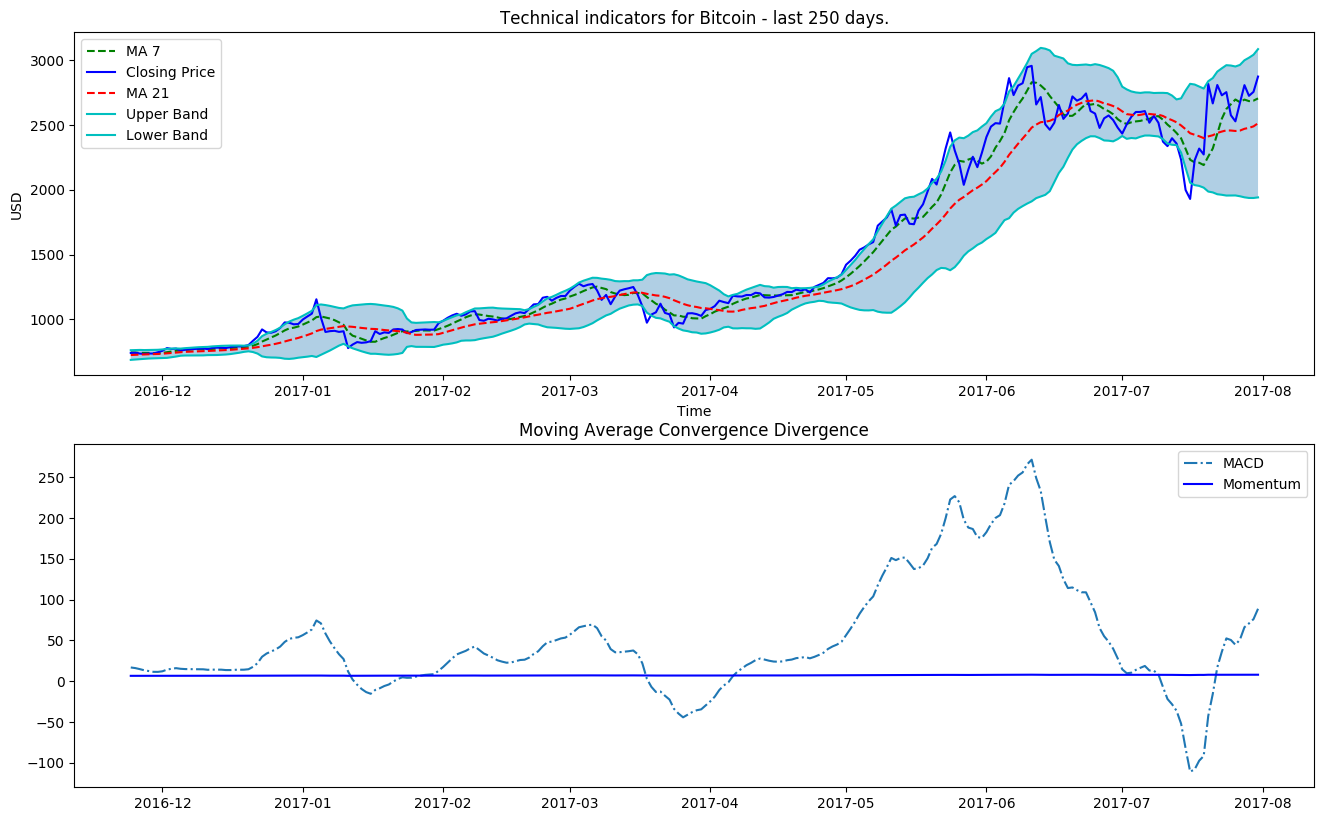

In [0]:
plot_technical_indicators(df_TI, 250)

*Fourier* transforms

In [0]:
close_fft = np.fft.fft(np.asarray(train['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning:

Casting complex values to real discards the imaginary part



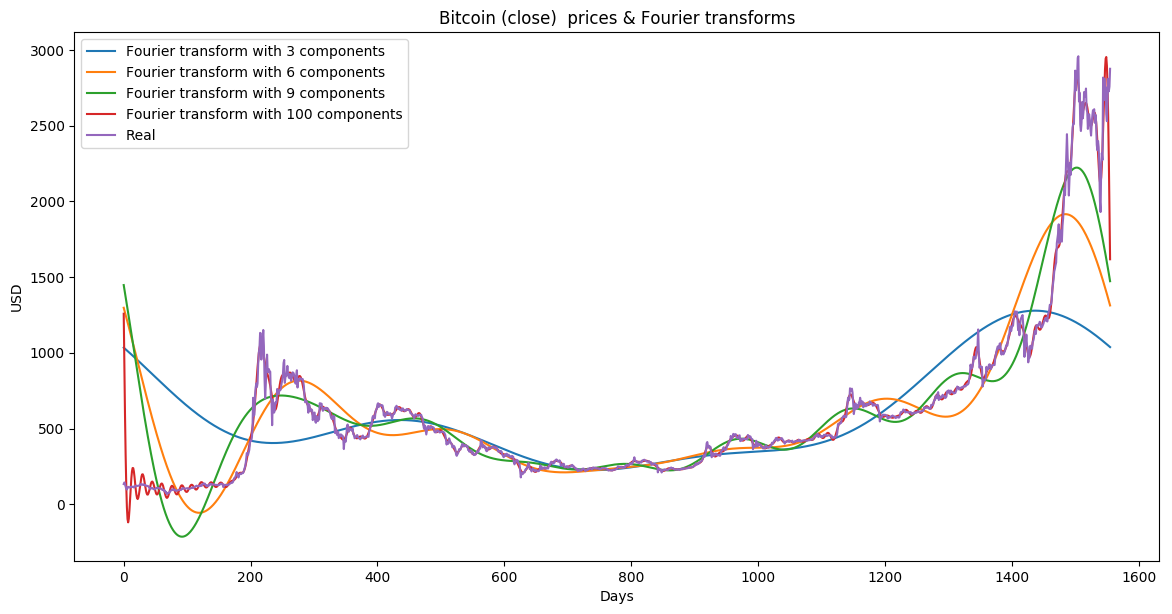

In [0]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(train['Close'].tolist(),  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Bitcoin (close)  prices & Fourier transforms')
plt.legend()
plt.show()

# ***Method 1***  

moving average

In [0]:
win_size = 7


7-day moving average (train): 2429.601511 MSE (49.290988 RMSE) 
7-day moving average (test): 81516.147691 MSE (285.510329 RMSE) 


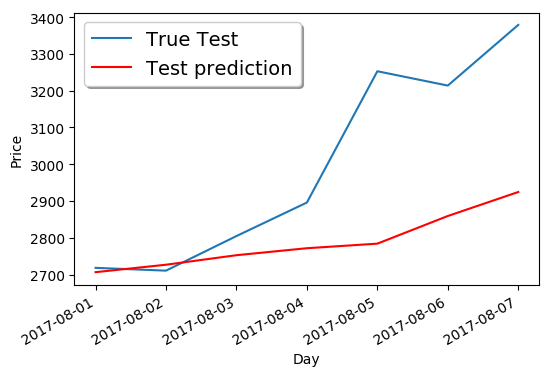

In [0]:
#Train 7-day ma

tr = df_TI.Close.to_numpy().reshape(-1, 1)
ma7 = df_TI.ma7.to_numpy().reshape(-1, 1)

mse = mean_squared_error(tr[win_size-1:],ma7[win_size-1:])
rmse = np.sqrt(mse)
print(f'{win_size}-day moving average (train): {mse:5f} MSE ({rmse:5f} RMSE) ')


#Test 7-day ma
predict = pd.DataFrame(pd.concat([train.Close[-win_size:],test.Close],axis=0))
predict['ma7'] = predict.rolling(window=win_size).mean().shift()

tr = predict.Close.to_numpy().reshape(-1, 1)
ma7 = predict.ma7.to_numpy().reshape(-1, 1)

mse = mean_squared_error(tr[win_size:],ma7[win_size:])
rmse = np.sqrt(mse)

print(f'{win_size}-day moving average (test): {mse:5f} MSE ({rmse:5f} RMSE) ')

fig, ax = plt.subplots(dpi=100)

plt.plot(predict.Close[win_size:],label='True Test')
plt.plot(predict.ma7,color='r',label='Test prediction')
plt.xlabel('Day')
plt.ylabel('Price')
fig.autofmt_xdate()
plt.legend(fontsize=14,loc='best',shadow='bool')
plt.show()

# ***Method 2***  

exponential moving average

exponential moving average (train): 170.050623 MSE (13.040346 RMSE) 
exponential moving average (test): 1578.357314 MSE (39.728545 RMSE) 


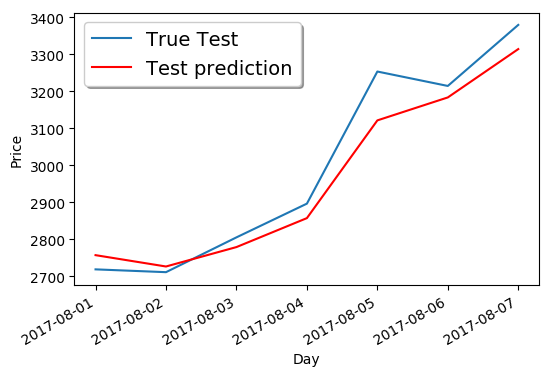

In [0]:
#Train
tr = df_TI.Close.to_numpy().reshape(-1, 1)
ema = df_TI.ema.to_numpy().reshape(-1, 1)

mse = mean_squared_error(tr,ema)
rmse = np.sqrt(mse)
print(f'exponential moving average (train): {mse:5f} MSE ({rmse:5f} RMSE) ')


#Test 
predict = pd.DataFrame(pd.concat([train.Close,test.Close],axis=0))
predict['ema'] = predict['Close'].ewm(com=0.5).mean()

tr = df_TI.Close.to_numpy().reshape(-1, 1)
ema = df_TI.ema.to_numpy().reshape(-1, 1)

size = test.shape[0]
mse = mean_squared_error(tr[-size:],ema[-size:])
rmse = np.sqrt(mse)

print(f'exponential moving average (test): {mse:5f} MSE ({rmse:5f} RMSE) ')

fig, ax = plt.subplots(dpi=100)

plt.plot(predict.Close[-size:],label='True Test')
plt.plot(predict.ema[-size:],color='r',label='Test prediction')
plt.xlabel('Day')
plt.ylabel('Price')
fig.autofmt_xdate()
plt.legend(fontsize=14,loc='best',shadow='bool')
plt.show()

**Lag plot**

strongly non-random, poistively linear


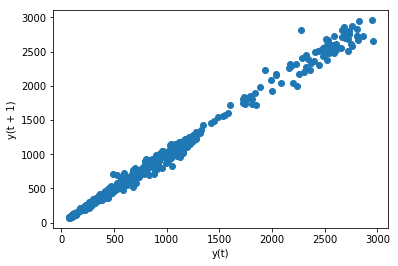

In [0]:
from pandas.plotting import lag_plot
lag_plot(train.Close)

print ("strongly non-random, poistively linear")

**Autocorrelatio**n

Strong correlation for lag<150


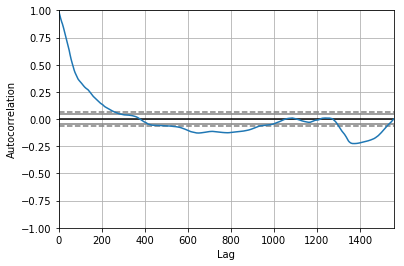

In [0]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train.Close)
print("Strong correlation for lag<150")

# ***Method 3***

In [0]:
train = train.sort_index(ascending=False)
test = test.sort_index(ascending=False,index_col=0)
test

TypeError: ignored

In [0]:
train = pd.read_csv('train.csv').sort_index(ascending=True)
train = train.sort_index(ascending=False)
train.set_index("Date",inplace=True)

test = pd.read_csv('test.csv').sort_index(ascending=True)
test = test.sort_index(ascending=False)
test.set_index("Date",inplace=True)

In [0]:
train.drop(['Volume'],1,inplace=True)
test.drop(['Volume'],1,inplace=True)

In [0]:
train['Market Cap'] = (train['Market Cap'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
test['Market Cap'] = (test['Market Cap'].str.split()).apply(lambda x: float(x[0].replace(',', '')))

In [0]:
scaler = MinMaxScaler()

In [0]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = scaler.fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

In [0]:
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [0]:
window = 20
X_train, y_train, X_test, y_test = preprocess_data(train, window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (1382, 20, 5)
y_train (1382,)
X_test (153, 20, 5)
y_test (153,)


In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM, GRU

Using TensorFlow backend.


In [0]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
#     model.add(LSTM(512, input_shape=(layers[1], layers[0]), return_sequences=True))
#     model.add(Dropout(d))
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
#     model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
        
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print(model.summary())

    return model

In [0]:
model = build_model([X_train.shape[2], window,1])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20, 256)           268288    
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 793,857
Trainable params: 793,857
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history = model.fit(X_train,y_train,batch_size=100,epochs=100,
#                     validation_split=0.1,
                    validation_data=(X_test,y_test),
                    verbose=1)

Train on 1382 samples, validate on 153 samples
Epoch 1/100
1382/1382 [==============================] - 1s 681us/step - loss: 0.0013 - acc: 0.0014 - val_loss: 0.0194 - val_acc: 0.0000e+00
Epoch 2/100
1382/1382 [==============================] - 1s 674us/step - loss: 0.0012 - acc: 0.0014 - val_loss: 0.0169 - val_acc: 0.0000e+00
Epoch 3/100
1382/1382 [==============================] - 1s 642us/step - loss: 9.6912e-04 - acc: 0.0014 - val_loss: 0.0149 - val_acc: 0.0000e+00
Epoch 4/100
1382/1382 [==============================] - 1s 627us/step - loss: 9.7215e-04 - acc: 0.0014 - val_loss: 0.0134 - val_acc: 0.0000e+00
Epoch 5/100
1382/1382 [==============================] - 1s 627us/step - loss: 8.3829e-04 - acc: 0.0014 - val_loss: 0.0126 - val_acc: 0.0000e+00
Epoch 6/100
1382/1382 [==============================] - 1s 628us/step - loss: 0.0011 - acc: 0.0014 - val_loss: 0.0401 - val_acc: 0.0000e+00
Epoch 7/100
1382/1382 [==============================] - 1s 631us/step - loss: 0.0015 - acc: 0.

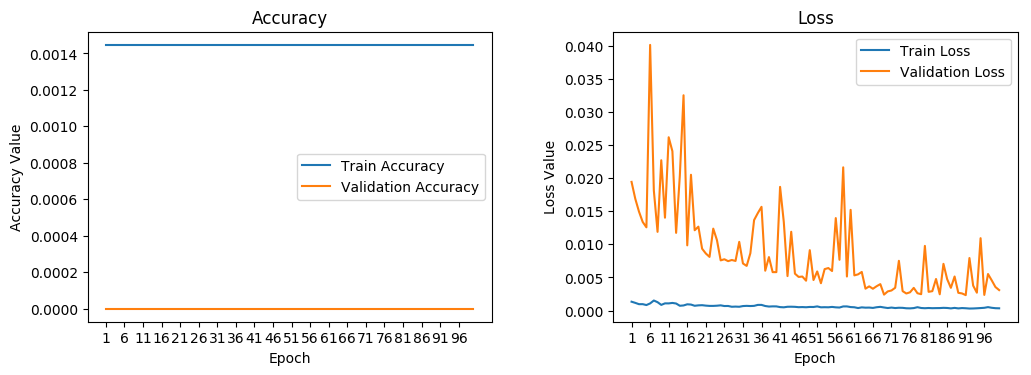

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=100)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['acc'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))


model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00010 MSE (0.01 RMSE)
Test Score: 0.00310 MSE (0.06 RMSE)


denormalize

In [0]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

In [0]:
def denormalize(df, normalized_value): 
    df = df.values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    a = scaler.fit_transform(df)
    new = scaler.inverse_transform(normalized_value)
    return new

new_pred = denormalize(train, pred)
newy_test = denormalize(train, y_test)

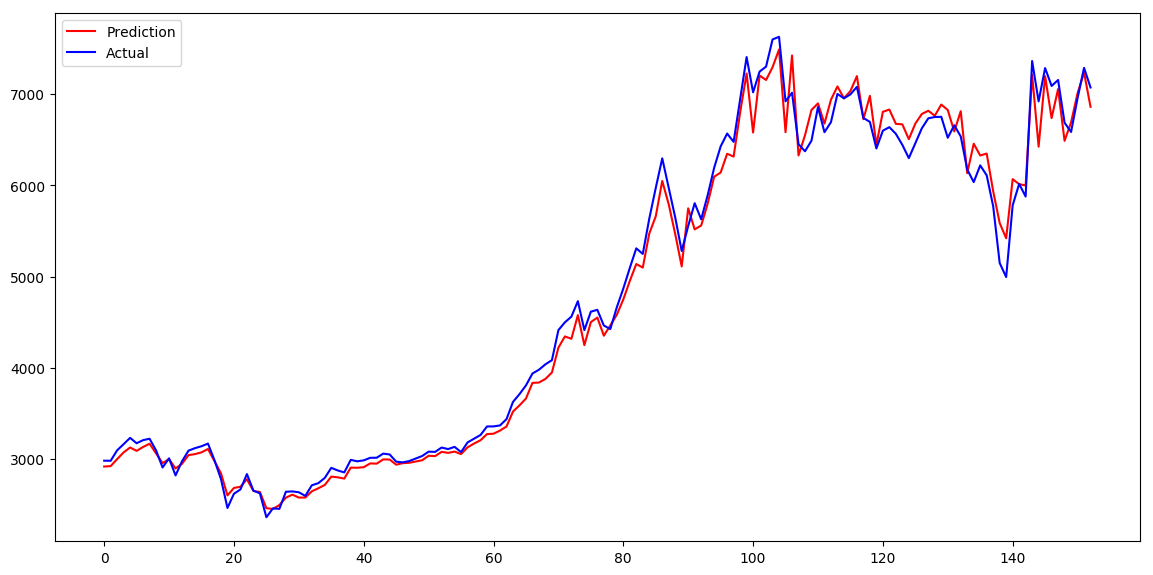

In [0]:
plt.figure(figsize=(14, 7), dpi=100)

plt.plot(new_pred,color='red', label='Prediction')
plt.plot(newy_test,color='blue', label='Actual')

plt.legend(loc='best')
plt.show()